In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Medical MNIST Data Set

torch: The core PyTorch library, used for creating tensors and building neural networks.
torchvision.datasets: Provides tools to load datasets, including ImageFolder, which reads datasets organized by directories.
torchvision.transforms: Contains utilities for preprocessing and augmenting images, such as resizing, normalizing, etc.
torch.utils.data.DataLoader: A PyTorch utility for creating efficient data loaders to fetch mini-batches during training/testing.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Paths to dataset
dataset_path = '/kaggle/input/medical-mnist'

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = dataset.classes  # ['AbdomenCT', 'BreastMRI', ...]
print("Classes:", class_names)


Classes: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


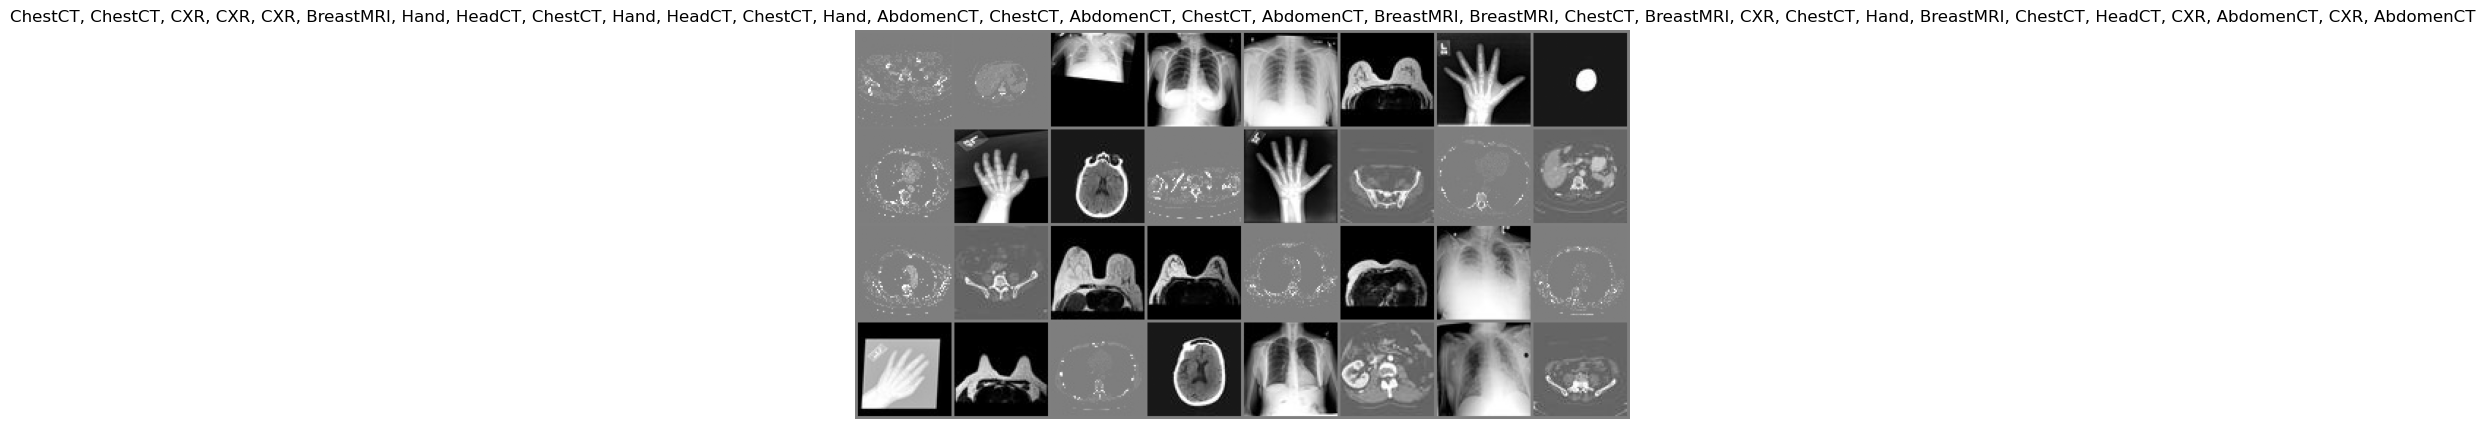

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid  # Import make_grid directly

# Helper function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # Adjust figure size for better visualization
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(", ".join(title))  # Display class names as a single string
    plt.axis('off')  # Turn off axis for cleaner visualization
    plt.show()

# Display a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(make_grid(images), title=[class_names[label] for label in labels])


## ANN

In [ ]:
import torch.nn as nn

class MedicalMNISTModel(nn.Module):
    def __init__(self, num_classes):
        super(MedicalMNISTModel, self).__init__()
        # Flatten input directly into a fully connected layer
        self.fc1 = nn.Linear(1 * 64 * 64, 128)  # Input size 64x64 (grayscale image flattened)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image (64x64)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [5]:
import torch.nn as nn

class MedicalMNISTModel(nn.Module):
    def __init__(self, num_classes):
        super(MedicalMNISTModel, self).__init__()
        self.fc1 = nn.Linear(1 * 64 * 64, 128)  # Input size 64x64 (grayscale image flattened)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image (64x64)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


# Initialize model
num_classes = len(class_names)  # Set the number of classes based on your dataset
model = MedicalMNISTModel(num_classes=num_classes).to('cuda')  # Move model to GPU if available

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        
        # Flatten input images for ANN
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the image to a 1D vector

        optimizer.zero_grad() # Clears any previously accumulated gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss for reporting

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad(): # ensures that no gradients are calculated during the inference phase
    for inputs, targets in test_loader: # Loops over the testing dataset
        inputs, targets = inputs.to('cuda'), targets.to('cuda')

        # Flatten input images for ANN
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the image to a 1D vector

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/2, Loss: 0.0787
Epoch 2/2, Loss: 0.0204
Test Accuracy: 99.62%


## CNN

In [4]:
import torch.nn as nn

class MedicalMNISTModel(nn.Module):
    def __init__(self, num_classes):
        super(MedicalMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input channels = 1 (grayscale)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust dimensions for 64x64 input
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [5]:
# Initialize model
num_classes = len(class_names)
model = MedicalMNISTModel(num_classes=num_classes).to('cuda')  # Move to GPU if available

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10, Loss: 0.0249
Epoch 2/10, Loss: 0.0037
Epoch 3/10, Loss: 0.0036
Epoch 4/10, Loss: 0.0007
Epoch 5/10, Loss: 0.0012
Epoch 6/10, Loss: 0.0015
Epoch 7/10, Loss: 0.0018
Epoch 8/10, Loss: 0.0021
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0002
Test Accuracy: 99.92%
